In [87]:
import gudhi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.ao.nn.quantized.functional import threshold
from tqdm import tqdm_pandas
from traffic.core import Flight
from collections import deque

from functions.data_loading import get_filtered_data_range, get_data_range, get_flight_persistence, get_removed_outliers
from functions.data_filtering import complete_flight_filter
from functions.data_filtering import filter_by_bools, filter_flights

from datetime import datetime
import pickle

In [88]:
origin = "amsterdam"
destination = "heathrow"

unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2023, month=2, day=1))
filtered_flights, file_name = get_filtered_data_range(unfiltered_flights, file_name, complete_flight_filter(origin, destination, 0.75)) 
del unfiltered_flights
#persistences, file_name = get_flight_persistence(filtered_flights, file_name)

In [89]:
def build_sublevelset_filtration(Y):
    """
    Y: array-like
        Array of function values
    """
    st = gudhi.SimplexTree()
    for i in range(len(Y)):
        # 0-simplices
        st.insert([i], filtration=Y.iloc[i])

        if i < len(Y) - 1:
            # 1-simplices
            st.insert([i, i + 1], filtration=max(Y.iloc[i], Y.iloc[i + 1]))

    return st

In [91]:
def remove_spikes_median(altitude, window_size=3, threshold=250):
    """
    Removes spikes from altitude data using a running median filter, including handling spikes at the start.
    
    Parameters:
        altitude (list or pd.Series): The altitude data to process.
        window_size (int): The size of the window for the running median. Must be odd.
        threshold (float): The maximum allowed deviation from the running median.
    
    Returns:
        pd.Series: The cleaned altitude data.
    """
    if window_size % 2 == 0:
        raise ValueError("Window size must be odd for a running median.")
    
    # Initialize a deque for the sliding window
    window = deque(maxlen=window_size)
    cleaned = []
    
    for i, value in enumerate(altitude):
        if pd.isna(value):
            # If the current value is NA, replace it with the last valid value or 0 if it's the first
            cleaned.append(cleaned[-1] if cleaned else 0)
        else:
            # Add the current value to the window
            window.append(value)
            
            if len(window) < window_size:
                # For early indices, use the median of available values in the window
                median = np.median(list(window))
            else:
                # Use the running median for a fully populated window
                median = np.median(list(window))
            
            # Check if the value deviates significantly from the median
            if abs(value - median) <= threshold:
                cleaned.append(value)
            else:
                # Replace the value with the median
                cleaned.append(median)
    
    return pd.Series(cleaned)

In [92]:
def get_sublevelset_filtration(flight: Flight):
    data = flight.data
    data = pd.DataFrame(data={"geoaltitude":list(data["geoaltitude"])},
                        index=pd.DatetimeIndex(data["timestamp"])).dropna()
    data = data["geoaltitude"].astype("float32").interpolate("time")
    data = remove_spikes_median(data)

    st = build_sublevelset_filtration(data)
    st.persistence()
    return st

In [93]:
from tqdm import tqdm
trees = []

for f in tqdm(filtered_flights):
    trees.append(get_sublevelset_filtration(f))

100%|██████████| 470/470 [00:17<00:00, 26.47it/s]


In [94]:
condensed_distance_matrix = []
for i in tqdm(range(len(trees))):
    for j in range(i+1, len(trees)):
        pers_i = trees[i].persistence_intervals_in_dimension(0)
        pers_j = trees[j].persistence_intervals_in_dimension(0)
        dist = gudhi.bottleneck_distance(np.array(pers_i), np.array(pers_j), 0.0001)
        condensed_distance_matrix.append(dist)

100%|██████████| 470/470 [00:42<00:00, 11.03it/s]


In [95]:
with open("data/condensed_distance_matrix.pkl", "wb") as f:
    pickle.dump(condensed_distance_matrix, f)

In [96]:
with open("data/condensed_distance_matrix.pkl", "rb") as f:
    condensed_distance_matrix = pickle.load(f)

In [112]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import sys
sys.setrecursionlimit(10000)

Z = linkage(condensed_distance_matrix, "complete")

#fig = plt.figure(figsize=(100, 10))
#dn = dendrogram(Z)

#clustering = fcluster(Z, t=2, criterion='inconsistent', depth=3)
clustering = fcluster(Z, t=4, criterion='maxclust', depth=2)


In [113]:
for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 38
2: 13
3: 418
4: 1


In [103]:
from traffic.core import Traffic

bool_array = clustering == 2

loopy_flight_cluster = filter_flights(filter_by_bools(bool_array), filtered_flights)
loopy_flight_cluster_pers = list(filter(filter_by_bools(bool_array), trees))
print(len(loopy_flight_cluster))

13


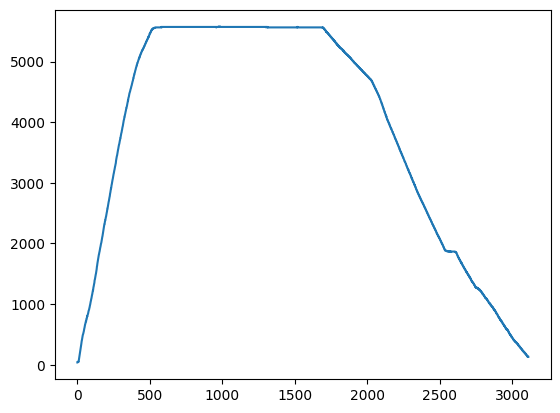

In [110]:
i = 6
data = remove_spikes_median(loopy_flight_cluster[i].data["geoaltitude"])
x_values = [x for x in range(len(data))]
plt.plot(x_values, data)

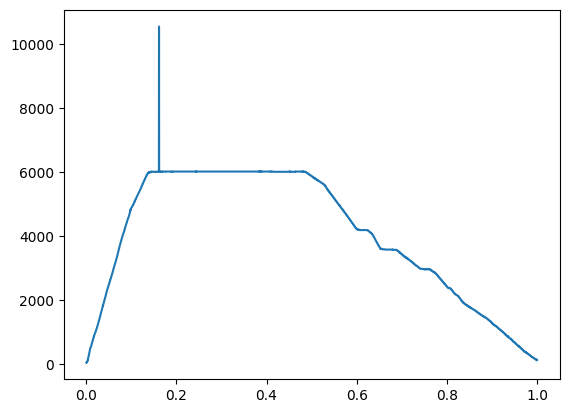

In [101]:
data = loopy_flight_cluster[i].data["geoaltitude"]
x_values = [x / len(data) for x in range(len(data))]
plt.plot(x_values, data, 100)